Connected to base (Python 3.11.11)

In [ ]:
import numpy as np
import pandas as pd
from nelson_langer_network import build_nelson_network
import time
from astrochem_clustering import AstrochemClusterModel

# Load parameters
datafile = np.load('data/tracer_parameter_data.npy')
datafile[:,0] *= 2
# ['nH', 'T', 'XH2', 'FUV', 'NH', 'zeta'] are the columns of datafile
data = datafile[:,[0, 1, 3]]
# data = datafile[:,[0, 1]]
data[:,[0,1]] = np.log10(data[:,[0,1]])
# data[:,2] /= 8.94e-14
params = pd.DataFrame(data=data, columns=['$\log(n_h)$', '$\log(T)$', '$G_0$'])

# Data for ode solves
# [H_2, H_3^+, e, He, He^+, C, CH_x, O, OH_x, CO, HCO^+, C^+, M^+, M]
#  0    1      2  3   4     5  6     7  8     9   10     11   12   13

# These are the initial conditions used by Nina in her testing code
x0 = np.array([
    0.5,
    9.059e-9,
    2e-4,
    0.1,
    7.866e-7,
    0.0,
    0.0,
    0.0004,
    0.0,
    0.0,
    0.0,
    0.0002,
    2.0e-7,
    2.0e-7
])
# From the overleaf doc
# x0 = np.array([
    # what should go here anyways?
# ])

secs_per_year = 3600*24*365
tf = 10000 * secs_per_year


def solve_nelson_network(params_row: np.ndarray, x0: np.ndarray, QoI: np.ndarray, time: float):
    n_h = 10**params_row[0]
    T = 10**params_row[1]
    G0 = params_row[2]
    network = build_nelson_network(n_h = n_h, T = T, G0 = G0)
    tvec, yvec = network.solve_reaction([0, time], x0)
    return yvec[QoI, -1]

In [ ]:
foo = np.load('data/medium_dataset_with_ode_solves.npy')
medium_dataset = pd.DataFrame(data=foo, columns=[
    '$\log(n_h)$',
    '$\log(T)$',
    '$G_0$',
    'e (t=100Y)',
    'H_2 (t=100Y)',
    'H_3+ (t=100Y)',
    'CO (t=100Y)',
    'C (t=100Y)',
    'e (t=1000Y)',
    'H_2 (t=1000Y)',
    'H_3+ (t=1000Y)',
    'CO (t=1000Y)',
    'C (t=1000Y)',
    'e (t=10000Y)',
    'H_2 (t=10000Y)',
    'H_3+ (t=10000Y)',
    'CO (t=10000Y)',
    'C (t=10000Y)',
])
np.random.seed(1234)
msk = np.random.rand(len(medium_dataset)) > 0.2
train = medium_dataset[msk]
test = medium_dataset[~msk]

In [ ]:
#    i.e. each training data point as a cluster centroid.
import faiss
centroids = train.to_numpy()[:,[0,1,2]]
QoI_values = train.to_numpy()[:,[13,14,15,16,17]]
faiss_index = faiss.IndexFlatL2(3)
faiss_index.add(centroids)

start_time = time.perf_counter()
D, I = faiss_index.search(test.to_numpy()[:,[0,1,2]], 1)
end_time = time.perf_counter()
total_time = end_time - start_time # in seconds
print(f'Time: {total_time:.2f} seconds')

datamat = np.zeros(shape=(len(test),16))
datamat[:,[0,1,2,3,4]] = test.to_numpy()[:,[13,14,15,16,17]] # exact (already solved)
I = np.matrix.flatten(I)
datamat[:,5] = I
datamat[:,[6,7,8,9,10]] = QoI_values[I] # predicted values
datamat[:,[11,12,13,14,15]] = np.abs(datamat[:,[6,7,8,9,10]] - datamat[:,[0,1,2,3,4]]) / np.abs(datamat[:,[0,1,2,3,4]])

Time: 0.03 seconds


In [ ]:
ind = 11
print('Stats for e')
print(f'Mean: {np.mean(datamat[:,ind])}')
print(f'Median: {np.median(datamat[:,ind])}')
print(f'Max: {np.max(datamat[:,ind])}')
print(f'STD: {np.std(datamat[:,ind])}')
num_vals_outside_error = (datamat[:,ind] > 0.1).sum()
print(f'# of points outside error: {num_vals_outside_error} ({num_vals_outside_error/len(datamat[:,2])}% of data)')

Stats for e
Mean: 0.005695717142715872
Median: 0.0034687010450172363
Max: 0.14546811622306594
STD: 0.007662454507280159
# of points outside error: 7 (0.0005865102639296188% of data)


In [ ]:
ind = 12
print('Stats for H2')
print(f'Mean: {np.mean(datamat[:,ind])}')
print(f'Median: {np.median(datamat[:,ind])}')
print(f'Max: {np.max(datamat[:,ind])}')
print(f'STD: {np.std(datamat[:,ind])}')
num_vals_outside_error = (datamat[:,ind] > 0.1).sum()
print(f'# of points outside error: {num_vals_outside_error} ({num_vals_outside_error/len(datamat[:,2])}% of data)')

Stats for H2
Mean: 8.854974142663264e-08
Median: 5.474373521661991e-08
Max: 7.040048395224196e-06
STD: 1.7220531134156385e-07
# of points outside error: 0 (0.0% of data)


In [ ]:
ind = 13
print('Stats for H3+')
print(f'Mean: {np.mean(datamat[:,ind])}')
print(f'Median: {np.median(datamat[:,ind])}')
print(f'Max: {np.max(datamat[:,ind])}')
print(f'STD: {np.std(datamat[:,ind])}')
num_vals_outside_error = (datamat[:,ind] > 0.1).sum()
print(f'# of points outside error: {num_vals_outside_error} ({num_vals_outside_error/len(datamat[:,2])}% of data)')

Stats for H3+
Mean: 0.0073656776175254025
Median: 0.004141575994009885
Max: 0.8581918469980521
STD: 0.014606566602254907
# of points outside error: 41 (0.0034352744030163385% of data)


In [ ]:
ind = 14
print('Stats for CO')
print(f'Mean: {np.mean(datamat[:,ind])}')
print(f'Median: {np.median(datamat[:,ind])}')
print(f'Max: {np.max(datamat[:,ind])}')
print(f'STD: {np.std(datamat[:,ind])}')
num_vals_outside_error = (datamat[:,ind] > 0.1).sum()
print(f'# of points outside error: {num_vals_outside_error} ({num_vals_outside_error/len(datamat[:,2])}% of data)')

Stats for CO
Mean: 0.01426308743089366
Median: 0.0050390706918618565
Max: 42.783456904677635
STD: 0.3920066344766648
# of points outside error: 93 (0.007792207792207792% of data)


In [ ]:
ind = 15
print('Stats for C')
print(f'Mean: {np.mean(datamat[:,ind])}')
print(f'Median: {np.median(datamat[:,ind])}')
print(f'Max: {np.max(datamat[:,ind])}')
print(f'STD: {np.std(datamat[:,ind])}')
num_vals_outside_error = (datamat[:,ind] > 0.1).sum()
print(f'# of points outside error: {num_vals_outside_error} ({num_vals_outside_error/len(datamat[:,2])}% of data)')

Stats for C
Mean: 0.0056246858683174925
Median: 0.0017342597861631605
Max: 6.066918432854698
STD: 0.05671361406228392
# of points outside error: 30 (0.0025136154168412233% of data)


(array([1.0367e+04, 9.8400e+02, 2.8800e+02, 1.2300e+02, 5.9000e+01,
        2.5000e+01, 2.3000e+01, 1.4000e+01, 1.2000e+01, 1.0000e+01,
        6.0000e+00, 5.0000e+00, 0.0000e+00, 5.0000e+00, 2.0000e+00,
        3.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29]),
 <BarContainer object of 29 artists>)

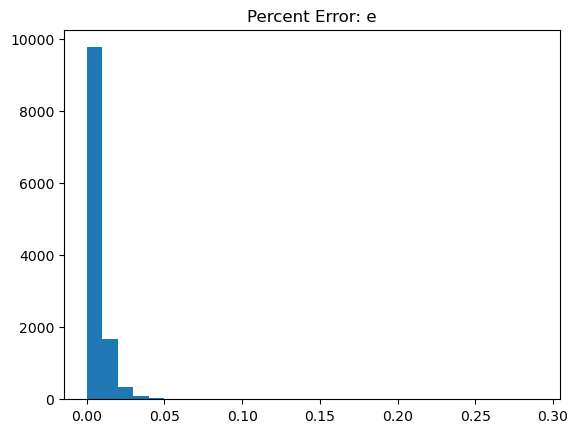

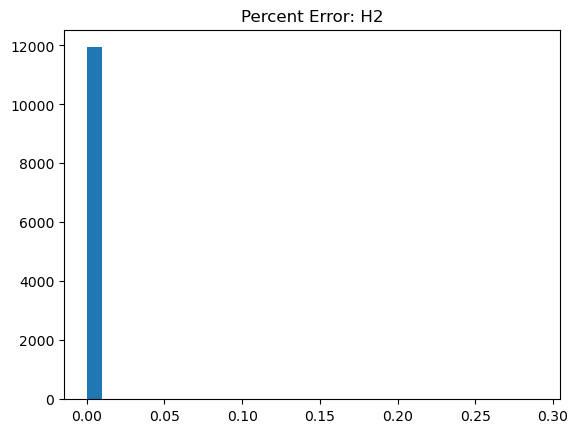

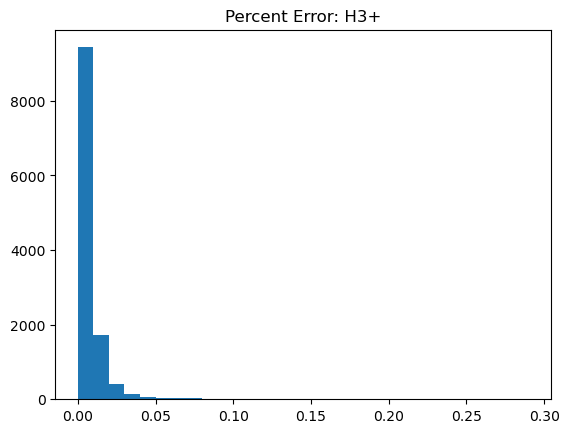

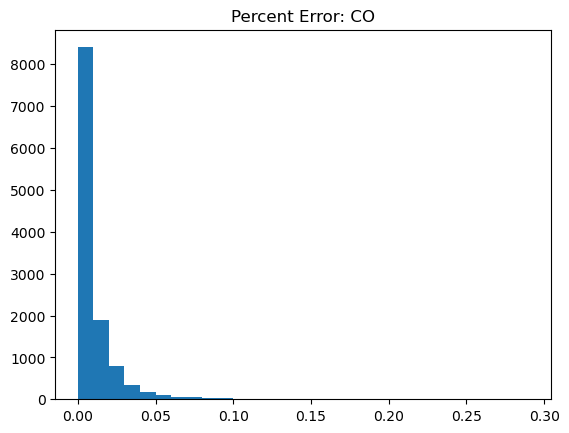

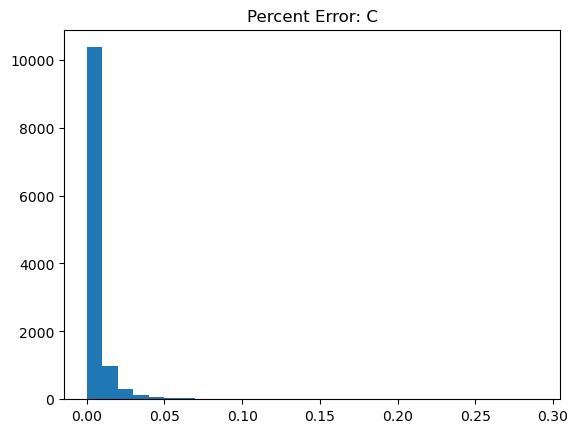

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.title('Percent Error: e')
plt.hist(datamat[:,11], bins=np.arange(0, 0.3, 0.01))
plt.figure()
plt.title('Percent Error: H2')
plt.hist(datamat[:,12], bins=np.arange(0, 0.3, 0.01))
plt.figure()
plt.title('Percent Error: H3+')
plt.hist(datamat[:,13], bins=np.arange(0, 0.3, 0.01))
plt.figure()
plt.title('Percent Error: CO')
plt.hist(datamat[:,14], bins=np.arange(0, 0.3, 0.01))
plt.figure()
plt.title('Percent Error: C')
plt.hist(datamat[:,15], bins=np.arange(0, 0.3, 0.01))